In [19]:
# Set up session
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=cI-RpLiam-e89ql17MBrKh0yzYVKl7QVe-h6k-WoPZI&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g6OaZvA4IIT1iWdyzPHvhGextJQ23Oli3Ys_Zk7q-4RGgAnisT8Qt8

Successfully saved authorization token.


### Extract data from satellite image

In [56]:
%matplotlib inline
from IPython.display import Image
import ee, datetime
import pandas as pd
from pylab import *
from matplotlib.pylab import rcParams

country = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017') \
  .filter(ee.Filter.eq('country_na', 'Egypt'))

roi = ee.Geometry.BBox(22.5, 28.2, 22.6, 28.3)

point = ee.Geometry.Point(22.558994, 28.469914)

# List of used image bands
band_list = ['EVI','NDVI','SummaryQA']

collection = ee.ImageCollection("MODIS/006/MOD13Q1").select(band_list)#.filterBounds(point)#.filterBounds(zoomed_out).filterDate('2000-01-01', '2019-12-31').sort('system:time_start', False)

count = collection.size()
print('Number of images in collection: ', str(count.getInfo())+'\n')

# Get info from the point
info = collection.getRegion(country, 50000).getInfo()    #.filterBounds(zoomed_out).getInfo() # change colelction by series

#print(info)

# Reshape image collection 
# Spearate header from data, and store data in an array
header = info[0]
data = array(info[1:])
#print(data)

# Extract time from data
iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)
#print(yData)

# Bryon's changes:
trees = yData[:,0] #tree cover
non_tree_veg = yData[:,1] #non-tree veg
non_veg = yData[:,2] #non-veg

# Reshape tree array into Pandas Dataframe
dfTC = pd.DataFrame(data=trees, columns=['EVI'])
dfTC['time'] = pd.Series(time, index=dfTC.index)

# get mean value for every year
groupTC =dfTC.dropna().groupby(['time'],as_index=False).mean()
#print(groupTC.head())


# Do same for non-tree vegetation
dfNT = pd.DataFrame(data=non_tree_veg, columns=['NDVI'])
dfNT['time'] = pd.Series(time, index=dfNT.index)
groupNT =dfNT.dropna().groupby(['time'],as_index=False).mean()
#print(groupNT.head())

# Do same for non-vegetated
dfNV = pd.DataFrame(data=non_veg, columns=['SummaryQA'])
dfNV['time'] = pd.Series(time, index=dfNV.index)
groupNV =dfNV.dropna().groupby(['time'],as_index=False).mean()
#print(groupNT.time.head())
print(groupNT.head())


Number of images in collection:  476

        time         NDVI
0 2000-02-18  1188.356481
1 2000-03-05  1197.585648
2 2000-03-21  1187.981481
3 2000-04-06  1155.687500
4 2000-04-22  1117.418981


In [ ]:
'''band_list = ['EVI','NDVI','DetailedQA']

collection = ee.ImageCollection("MODIS/006/MOD13Q1").filter(ee.Filter.lte('DetailedQA', 1))#.filter(ee.Filter.notNull(['NIR']))#.select(band_list).filter(ee.Filter.notNull(['NIR'])).select(band_list)
count = collection.size()
print('Number of images in collection: ', str(count.getInfo())+'\n')'''

## Visualise

In [ ]:
import folium
#!pip install geehydro
import geehydro

In [ ]:
collection = ee.ImageCollection('MODIS/006/MOD13Q1')
lay1 = collection.filterDate('2019-01-01', '2019-12-31').select("SummaryQA")#.getRegion(country)
lay2 = collection.filterDate('2019-01-01', '2019-12-31').select("NDVI")
map = folium.Map(location = [22.558994, 28.469914], zoom_start=10)
map.addLayer(lay1, {'min' : 0, 'max' : 4}, 'QA')
map.addLayer(lay2, {'min' : -2000, 'max' : 10000}, 'NDVI19')
folium.LayerControl().add_to(map)
map


## Remove data points with (very) bad quality

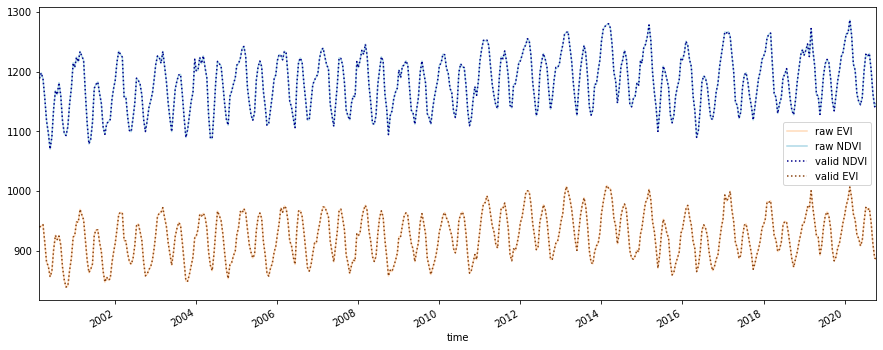

In [58]:
# Plotting
#print(groupNV)


todrop = groupNV['SummaryQA']>=2
toDrop = groupNV[todrop]


qqNT = groupNT.mask(todrop, inplace = False)
qqTC = groupTC.mask(todrop,inplace = False)
#groupNV['SummaryQA'] = groupNV['SummaryQA']*200

rcParams['figure.figsize'] = 15, 6

#axe = groupNV.plot(x='time', y='SummaryQA')#, kind = 'scatter')

axe = groupTC.plot(x='time', y='EVI', label='raw EVI', c='peachpuff')# ,ax=axe)
groupNT.plot(x='time', y='NDVI', label='raw NDVI' ,ax=axe, c='lightblue')

qqNT.plot(x='time', y='NDVI', label='valid NDVI',ax=axe, ls='dotted', c='darkblue')
qqTC.plot(x='time', y='EVI', label='valid EVI' ,ax=axe,ls='dotted',c='saddlebrown')

axe.autoscale(enable=True, axis='x', tight=True)

plt.show()


## FILTERING


In [59]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [60]:
y = np.array([qqNT['NDVI'] , qqTC['EVI']])     #qqNT.time,
#pd.concat(qqNT['NDVI'],qqTC['EVI'], axis=0)
print(y.shape)
print(qqNT.info())

(2, 476)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    476 non-null    datetime64[ns]
 1   NDVI    476 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.2 KB
None


In [61]:
M = 1
N = 2
A = np.eye(M)
H = np.ones((N, M)) / M
Q = np.eye(M)
R = np.eye(N) * 30

In [62]:
Nk = y.shape[1]

m = np.zeros((M, Nk))
P = np.zeros((M, M, Nk))

# Set prior mean and covariance explicitly:
m[:, 0] = np.nanmean(y[:, 0])
P[:, :, 0] = Q

mp = m.copy()
Pp = P.copy()

In [63]:
for k in range(1, Nk):
    # 1. Prediction step
    mp[:, k] = A.dot(m[:, k-1])
    Pp[:, :, k] = A.dot(P[:, :, k-1]).dot(A.T) + Q
    
    # If there is any missing data, skip update step
    if np.isnan(y[:, k]).any():
        m[:, k] = mp[:, k]
        P[:, :, k] = Pp[:, :, k]
        continue
        
    # 2. Update step
    v = y[:, k] - H.dot(mp[:, k])
    S = H.dot(Pp[:, :, k]).dot(H.T) + R
    K = Pp[:, :, k].dot(H.T).dot(np.linalg.inv(S))
    m[:, k] = mp[:, k] + K.dot(v)
    P[:, :, k] = Pp[:, :, k] - K.dot(S).dot(K.T)

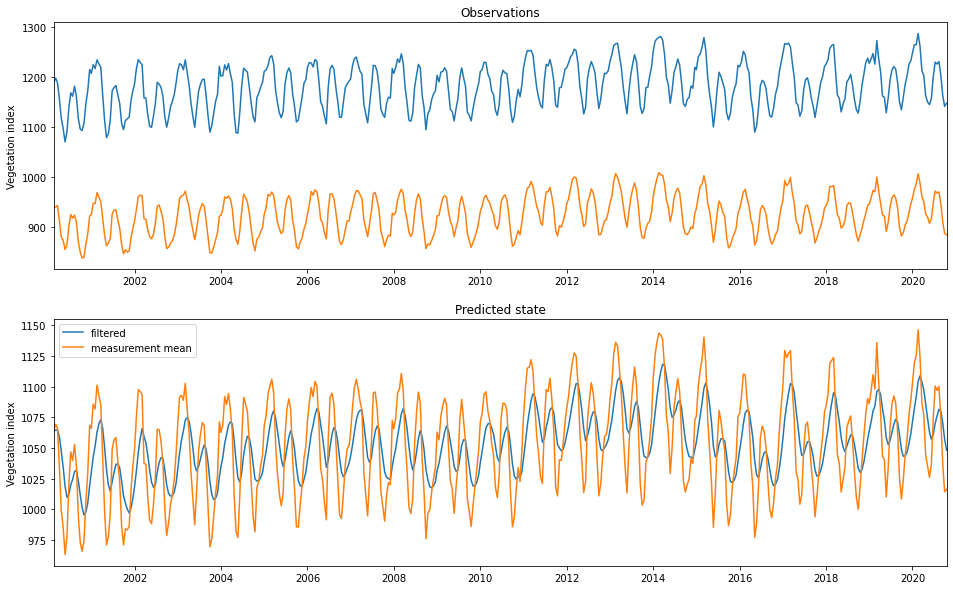

In [64]:
time = qqNT['time'].values

fig, ax = plt.subplots(2, 1, figsize=(16, 10))
ax[0].plot(time, y.T)
ax[0].set_title('Observations')
ax[1].plot(time, m.T, label='filtered')
ax[1].plot(time, y.mean(0), label='measurement mean')
ax[1].legend()
ax[1].set_title('Predicted state')
for a in ax:
    a.set_ylabel('Vegetation index')
    a.autoscale(enable=True, axis='x', tight=True)

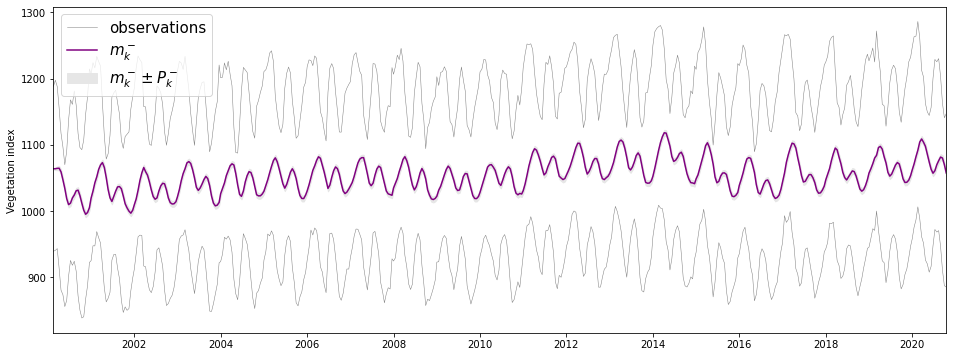

In [65]:
plt.figure(figsize=(16, 6))

# Plot the original observations
h = plt.plot(time, y.T, color='0.5', linewidth=0.5)
# Add legend entry for one of the lines
h[0].set_label('observations')

# Add gray band to indicate covariance
error = (Pp.diagonal(axis1=0, axis2=1)).flatten()

plt.fill_between(time, mp.flatten() - error, mp.flatten() + error, color='0.9', label='$m^-_k \pm P^-_k$')

# Plot predictive means
plt.plot(time, mp.T, color='purple', label='$m^-_k$')

#plt.ylim([270, 310])
plt.ylabel('Vegetation index')
plt.legend(fontsize=15)
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


0.8419224248140893


Text(0.5, 1.0, 'Autocorrelation')

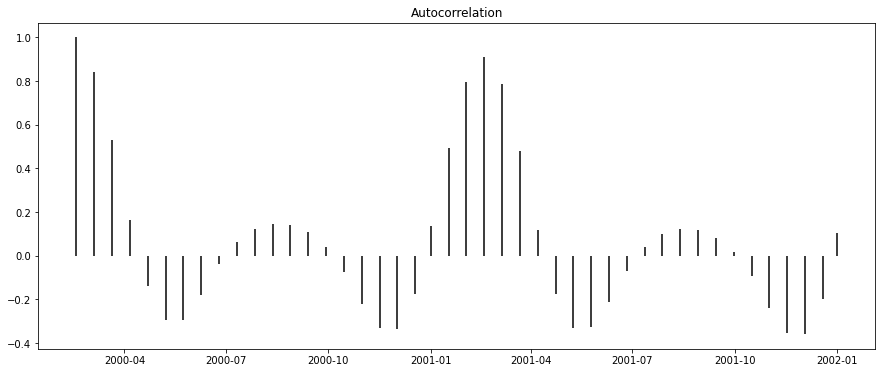

In [66]:
from statsmodels.graphics import tsaplots

# Display the autocorrelation plot of your time series
#fig = tsaplots.plot_acf(np.array(qqNT.NDVI))#, lags = 47)
#plt.show()
qqNT.NDVI.autocorr
print(qqNT.NDVI.autocorr())
d=44
acf = zeros(d)
for i in range(d) :
  acf[i]=qqNT.NDVI.autocorr(lag =i)

plt.vlines(time[0:d],0, acf)
plt.title('Autocorrelation')

0


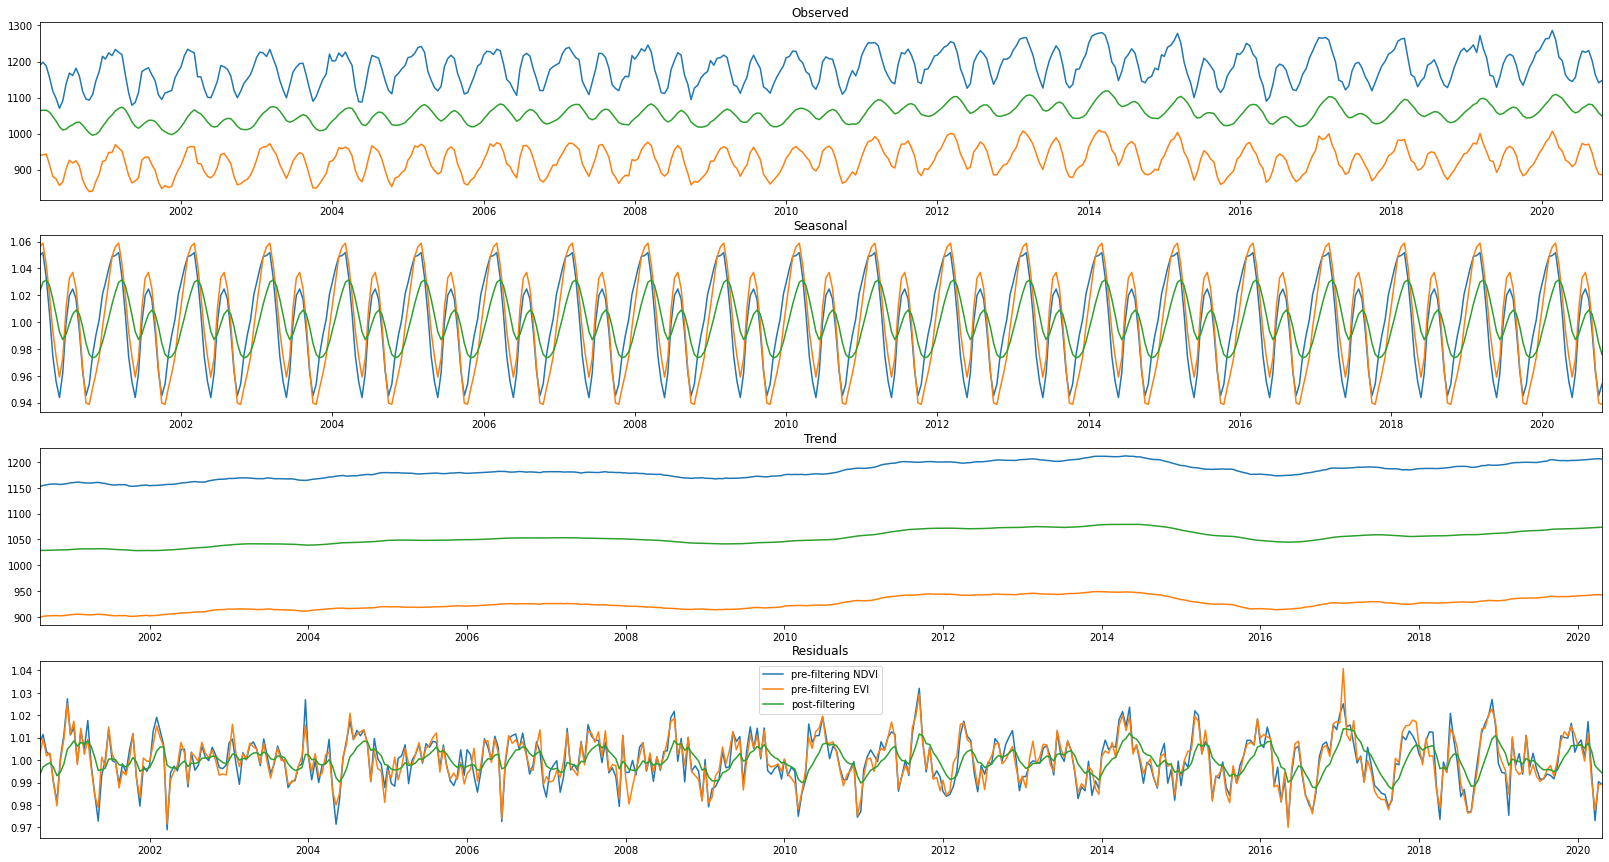

In [89]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# fill in missing values
y1 = qqNT.NDVI.fillna(qqNT.NDVI.bfill())

dec = seasonal_decompose(np.array(y1),model = 'multiplicative', freq = 23)
#print(dec.trend)
fig, ax = plt.subplots(4, 1, figsize=(28, 15))
plt.autoscale(enable=True, axis='x', tight=True)
plt.rcParams.update({'font.size': 10})
ax[0].plot(time, dec.observed, label = 'pre-filtering NDVI')
ax[0].title.set_text('Observed')
ax[1].plot(time, dec.seasonal, label = 'pre-filtering NDVI')
ax[1].title.set_text('Seasonal')
ax[2].plot(time, dec.trend, label = 'pre-filtering NDVI')
ax[2].title.set_text('Trend')
ax[3].plot(time, dec.resid, label = 'pre-filtering NDVI')
ax[3].title.set_text('Residuals')


#print(ax.convert_xunits(time))
print(qqTC.EVI.isnull().sum())

y2 = qqTC.EVI.fillna(qqTC.EVI.bfill())

dec = seasonal_decompose(np.array(y2),model = 'multiplicative', freq = 23)
#print(dec.trend)

ax[0].plot(time, dec.observed, label = 'pre-filtering EVI')
ax[0].title.set_text('Observed')
ax[1].plot(time, dec.seasonal, label = 'pre-filtering EVI')
ax[1].title.set_text('Seasonal')
ax[2].plot(time, dec.trend, label = 'pre-filtering EVI')
ax[2].title.set_text('Trend')
ax[3].plot(time, dec.resid, label = 'pre-filtering EVI')


dec = seasonal_decompose(m.flatten(),model = 'multiplicative', freq = 23)
#print(dec.trend)

ax[0].plot(time, dec.observed, label = 'post-filtering')
ax[0].title.set_text('Observed')
ax[1].plot(time, dec.seasonal, label = 'post-filtering')
ax[1].title.set_text('Seasonal')
ax[2].plot(time, dec.trend, label = 'post-filtering')
ax[2].title.set_text('Trend')
ax[3].plot(time, dec.resid, label = 'post-filtering')
plt.legend()
for a in ax:
    a.autoscale(enable=True, axis='x', tight=True)